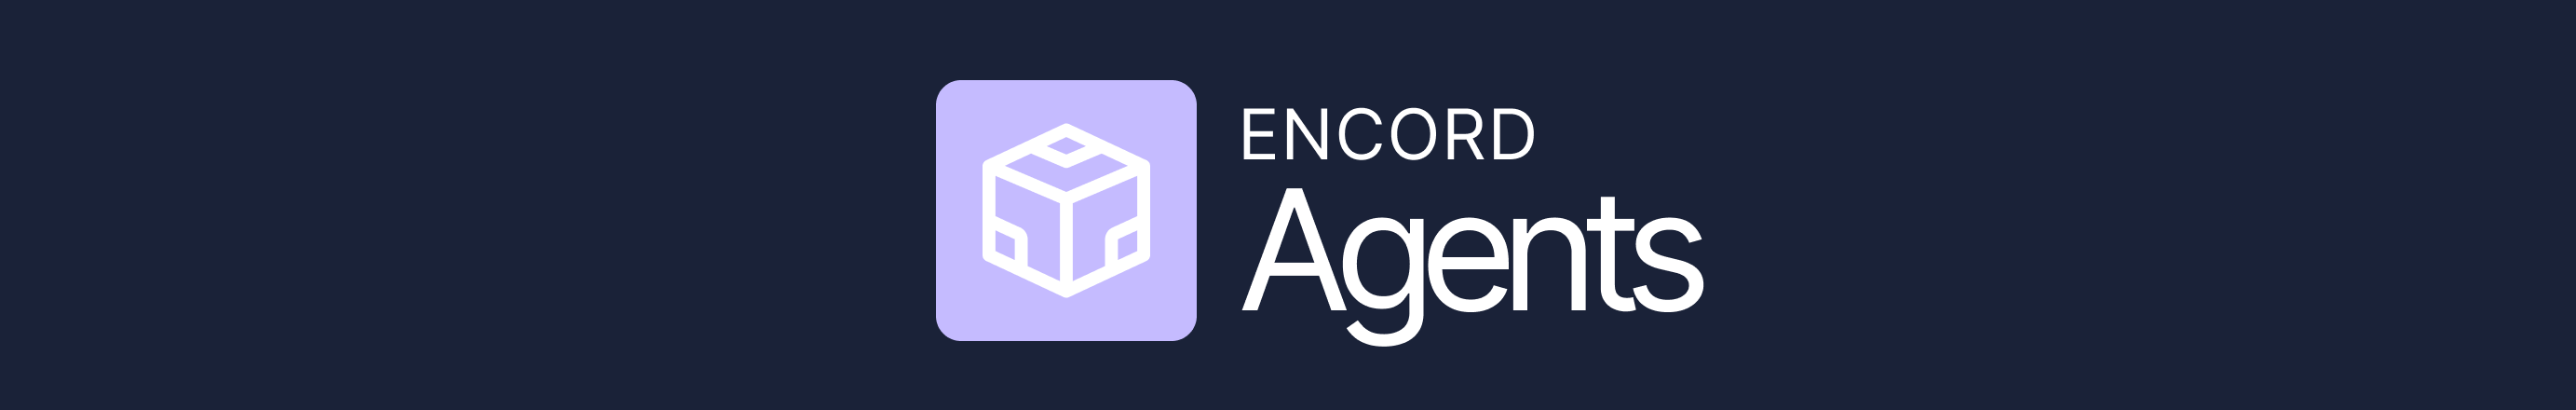

This notebook demonstrates how to use the Encord Agents Task Runner to create a video recaptioning workflow. We'll use the GPT-4o-mini model to automatically generate multiple captions based on a human-written description.

In the notebook, we follow the Workflow below.
Every video is being annotated with a caption by a human (the pink node).
Successively, a data agent produces multiple new captions automatically (the purple node).
Finally, a humans reviews all four captions (the yellow node) before the item is complete.
If there are no human captions when the task reaches the data agent, it'll send it back for annotation.
Similarly, if the task is rejected during review, it's also sent back for another round of annotation.


![Project workflow](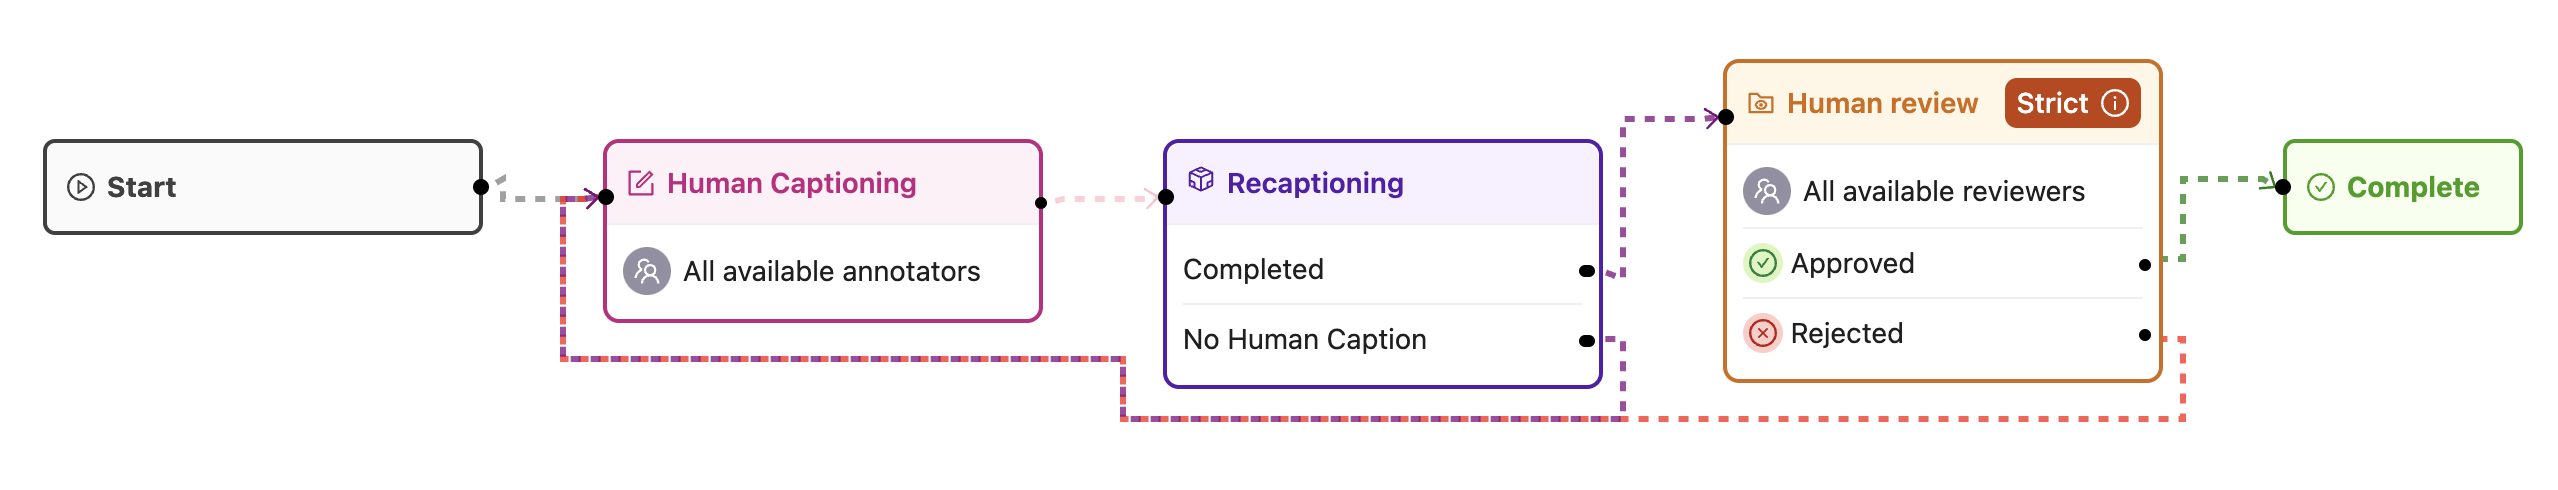
)

Annotations are done following the labeling ontology below.
The first field `"Caption"` is for the human to fill in.
The latter three recaptions are for the data agent to fill in.



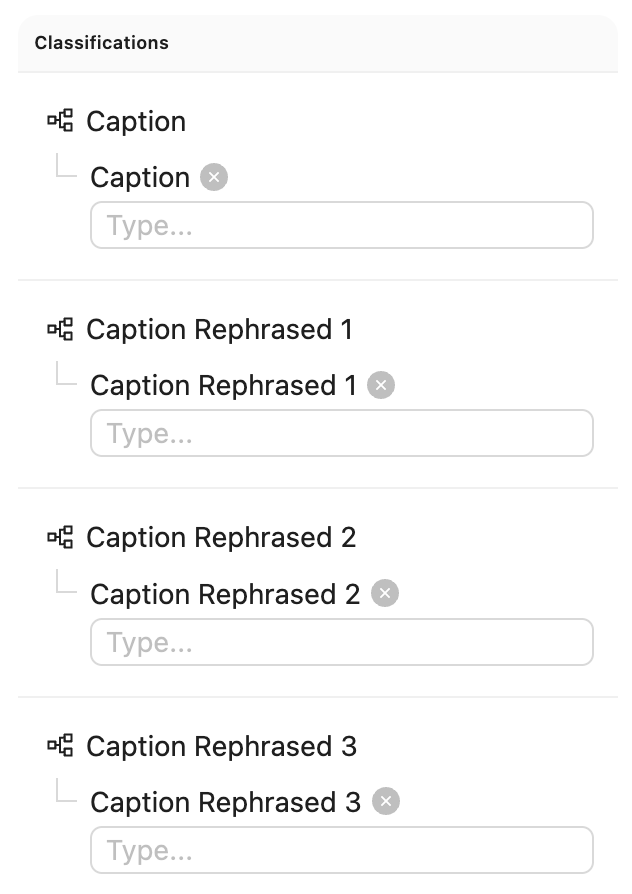


<details>
    <summary>Expand to see ontology JSON</summary>
<pre>
{
  "objects": [],
  "classifications": [
    {
      "id": "1",
      "featureNodeHash": "GCH8VHIK",
      "attributes": [
        {
          "id": "1.1",
          "name": "Caption",
          "type": "text",
          "required": false,
          "featureNodeHash": "Yg7xXEfC"
        }
      ]
    },
    {
      "id": "2",
      "featureNodeHash": "PwQAwYid",
      "attributes": [
        {
          "id": "2.1",
          "name": "Caption Rephrased 1",
          "type": "text",
          "required": false,
          "featureNodeHash": "aQdXJwbG"
        }
      ]
    },
    {
      "id": "3",
      "featureNodeHash": "3a/aSnHO",
      "attributes": [
        {
          "id": "3.1",
          "name": "Caption Rephrased 2",
          "type": "text",
          "required": false,
          "featureNodeHash": "8zY6H62x"
        }
      ]
    },
    {
      "id": "4",
      "featureNodeHash": "FNjXp5TU",
      "attributes": [
        {
          "id": "4.1",
          "name": "Caption Rephrased 3",
          "type": "text",
          "required": false,
          "featureNodeHash": "sKg1Kq/m"
        }
      ]
    }
  ]
}
</pre>
</details>
<details>
    <summary>Code for generating ontology</summary>
        <pre>
import json
from encord.objects.ontology_structure import OntologyStructure
from encord.objects.attributes import TextAttribute

structure = OntologyStructure()
caption = structure.add_classification()
caption.add_attribute(TextAttribute, "Caption")
re1 = structure.add_classification()
re1.add_attribute(TextAttribute, "Recaption 1")
re2 = structure.add_classification()
re2.add_attribute(TextAttribute, "Recaption 2")
re3 = structure.add_classification()
re3.add_attribute(TextAttribute, "Recaption 3")

print(json.dumps(structure.to_dict(), indent=2))

create_ontology = False
if create_ontology:
    from encord.user_client import EncordUserClient
    client = EncordUserClient.create_with_ssh_private_key()  # Look in auth section for authentication
    client.create_ontology("title", "description", structure)
            </pre>
        </p>

</details>

## How It Works

### Workflow Requirements

For this notebook to work, your project should have:

1. An ontology with four text classifications:
   - A text classification for a human-created caption
   - Three text classifications for the LLM to fill in

2. A workflow with at least one agent stage named "Recaptioning" and at least two pathways:
   - "Completed" - for tasks that successfully generated captions
   - "No Human Caption" - for tasks that had no human caption to work with

### Process Flow

1. The Runner periodically checks for tasks in the "Recaption Video" stage
2. For each task, it loads the label row and checks if there's a human-created caption
3. If a caption exists, it sends the caption and the first frame to GPT-4o-mini
4. The LLM generates three alternative captions
5. The agent adds these captions to the label row and saves it
6. The task moves to the "Completed" pathway

### Agent Customization

You can customize this agent by:
- Changing the system prompt to get different types of rephrases
- Using a different LLM model
- Adjusting the temperature for more or less creative outputs
- Adding more classification fields for additional types of captions



This notebook will walk through:
- Setting up the required dependencies
- Integrating GPT-4o-mini
- Implementing the task agent using the Runner
- Running the agent on your project

## Setup

First, let's install the required dependencies:

In [ ]:
!pip install encord-agents langchain-openai openai

### Authentication

**Encord**
Encord uses ssh-keys for authentication. The following is a code cell for setting the `ENCORD_SSH_KEY` environment variable. It contains the raw content of your private ssh key file.

If you have not setup an ssh key, see our [documentation](https://agents-docs.encord.com/authentication/).

**OpenAI**

We will also need an OpenAI api key to be able to interact with gptp-4o-mini.


> 💡 In colab, you can set the key once in the secrets in the left sidebar and load it in new notebooks. IF YOU ARE NOT RUNNING THE CODE IN THE COLLAB NOTEBOOK, you must set the environment variable directly.
> ```python
> os.environ["ENCORD_SSH_KEY"] = """paste-private-key-here"""
> os.environ["OPENAI_API_KEY"] = """openai-api-key"""
> ```


In [ ]:
import os

from google.colab import userdata

os.environ["ENCORD_SSH_KEY"] = userdata.get("ENCORD_SSH_KEY")
# or you can set a path to a file
# os.environ["ENCORD_SSH_KEY_FILE"] = "/path/to/your/private/key"

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

#### [Alternative] Temporary Key
There's also the option of generating a temporary (fresh) ssh key pair via the code cell below.
Please follow the instructions printed when executing the code.

In [ ]:
# ⚠️ Safe to skip if you have authenticated already
import os

from encord_agents.utils.colab import generate_public_private_key_pair_with_instructions

private_key_path, public_key_path = generate_public_private_key_pair_with_instructions()
os.environ["ENCORD_SSH_KEY_FILE"] = private_key_path.as_posix()

## Imports
Now let's import the necessary libraries:

In [ ]:
import os
from typing import Annotated

import numpy as np
from encord.objects.ontology_labels_impl import LabelRowV2
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

from encord_agents.tasks import Runner
from encord_agents.tasks.dependencies import Frame, dep_single_frame

## LLM Setup

Let's define the response model for the GPT-4o-mini to follow.
This is a convenient method for ensuring that we work with typed and well-defined python objects.

The class will govern what we want the LLM to return.
In this case, we want three different rephrasings of the given human caption.

In [ ]:
class AgentCaptionResponse(BaseModel):
    rephrase_1: str
    rephrase_2: str
    rephrase_3: str

Let's set up the LLM with the system prompt.

> 💡 You probably want to adjust this to your particular needs.

In [ ]:
# System prompt for the LLM to follow
SYSTEM_PROMPT = """
You are a helpful assistant that rephrases captions.

I will provide you with a video caption and an image of the scene of the video.

The captions follow this format:

"The droid picks up <cup_0> and puts it on the <table_0>."

The captions that you make should replace the tags, e.g., <cup_0>, with the actual object names.
The replacements should be consistent with the scene.

Here are three rephrases:

1. The droid picks up the blue mug and puts it on the left side of the table.
2. The droid picks up the cup and puts it to the left of the plate.
3. The droid is picking up the mug on the right side of the table and putting it down next to the plate.

You will rephrase the caption in three different ways, as above, the rephrases should be

1. Diverse in terms of adjectives, object relations, and object positions.
2. Sound in relation to the scene. You cannot talk about objects you cannot see.
3. Short and concise. Keep it within one sentence.
"""

# Create the LLM instance with structured output
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.4)
llm_structured = llm.with_structured_output(AgentCaptionResponse)

## Creating the LLM Prompt Function

Now let's create a function to prompt the LLM.

There are two particular things to notice here.

* The `image` that is passed in has a convenient method `b64_encoding` which allows converting the raw pixel values of the video frame into a base64 encoding compatible with the OpenAI API.
* The llm is bound to only return structured outputs. That is, we know (because we called `with_structured_output` above) that the LLM will return an `AgentCaptionResponse` instance.
* Since we want diversity in our recaptions, we set the temperature rather low.

In [ ]:
def prompt_gpt(caption: str, image: Frame) -> AgentCaptionResponse:
    """
    Prompt GPT with a caption and an image to get three rephrases of the caption.

    Args:
        caption: The original caption written by a human.
        image: The frame from the video that the caption refers to.

    Returns:
        A structured response with three rephrases of the original caption.
    """
    prompt = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"Video caption: `{caption}`"},
                image.b64_encoding(output_format="openai"),
            ],
        },
    ]
    return llm_structured.invoke(prompt)

## Creating the Task Agent

Now let's define our task agent.
There are a couple of things to pay attention to.

* The `dep_single_frame` will give the first frame of the video. We pass this on to GPT to ensure consistency in the recaptions.
* If there's no human caption, we send the task back to annotation.
* We upsert recaptions. That is, if they exist already, we overwrite otherwise we add.



In [ ]:
from numpy.typing import NDArray

from encord_agents.tasks import Depends

# Initialize the Runner with your project hash
runner = Runner(project_hash="<project_hash>")


# Register the recaption_agent with a specific stage in your workflow
@runner.stage("Recaptioning")
def recaption_task(
    label_row: LabelRowV2,
    frame_content: Annotated[NDArray[np.uint8], Depends(dep_single_frame)],
) -> None:
    # Get the relevant ontology information
    # Recall that we expect
    # [human annotation, llm recaption 1, llm recaption 2, llm recaption 3]
    # in the ontology
    cap, *rs = label_row.ontology_structure.classifications

    # Read the existing human caption if there are more captions,
    # we'll take the first one.
    instances = label_row.get_classification_instances(filter_ontology_classification=cap)
    if not instances:
        # nothing to do if there are no human labels
        return "No Human Caption"

    # Delete any existing recaptions
    for r in rs:
        existing_instances = label_row.get_classification_instances(filter_ontology_classification=r)
        for existing_instance in existing_instances:
            label_row.remove_classification(existing_instance)

    # Add new recaptions
    for instance in instances:
        # Read the actual string caption
        caption = instance.get_answer()
        frames = [a.frame for a in instance.get_annotations()]

        # Run the first frame of the video and the human caption
        # against the llm
        frame = Frame(frame=0, content=frame_content)
        response = prompt_gpt(caption, frame)

        # Upsert the new captions
        for r, t in zip(rs, [response.rephrase_1, response.rephrase_2, response.rephrase_3]):
            # Create new instances
            ins = r.create_instance()
            ins.set_answer(t, attribute=r.attributes[0])
            ins.set_for_frames(frames)
            label_row.add_classification_instance(ins)

        label_row.save()
    return "Completed"

## Running the Agent

Now we can run our agent on the project:

In [ ]:
# Set to refresh every 60 seconds to continuously check for new tasks
runner(refresh_every=60)

## Conclusion

In this notebook, we created a task agent that automatically generates alternative captions for videos based on human-written descriptions. The agent uses GPT-4o-mini to create diverse, natural, and concise rephrases of the original caption.

This approach can be extended to other use cases, such as:
- Generating descriptions in multiple languages
- Creating captions optimized for different purposes (marketing, accessibility, technical documentation)
- Building a dataset of varied descriptions for training computer vision models

By using the Encord Agent Task Runner, we've created a workflow that can process tasks in batches, automatically retry failed operations, and continuously monitor for new tasks.